# Exercise 4: Calibrate HBV model with ERA5 forcing and GRDC observation

In this notebook you will calibrate your own HBV model using ERA5 forcing data (from the previous notebook) and GRDC observation data. You will have to change a few settings below. Only a very simple (bad!) calibration is provided. It is up to you to optimize the calibration for your specific region. Read carefully and decide which inputs and lines to change.


In [1]:
# Load all dependencies, including your own model through ewatercycle_wrapper_HBV
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
from ipywidgets import IntProgress
from IPython.display import display

from ewatercycle_wrapper_HBV import HBV

/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set lisflood_fraser loaded in config but /data/shared/parameter-sets/lisflood_fraser does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set lisflood_fraser loaded in config but /data/shared/parameter-sets/lisflood_fraser/settings_lat_lon-Run.xml does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set pcrglobwb_rhinemeuse_30min loaded in config but /data/shared/parameter-sets/pcrglobwb_rhinemeuse_30min does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-p

In [2]:
# Name of your shapefile/region without extension:
own_region = "HN4326"  # for example: "Rhine"

if own_region == None:  # if nothing is provided, the Rhine shapefile will be used
    own_region = "Rhine"

In [3]:
# Shapefile that describes the basin we want to study.
path = Path.cwd()
forcing_path = path / "Forcing"
shapeFile = forcing_path / f"{own_region}.shp"

# Location to saved forcing results from previous notebook
forcingLocation = forcing_path / f"{own_region}Forcing"

# GRDC station ID for the observation station
# grdc_station_id = "6335020"  # GRDC station ID 
basin_name = own_region

# Period of interest. 
# Make sure that GRDC data is available for this period and that it matches your forcing data
experiment_start_time = "2010-01-02T00:00:00Z"
experiment_end_time = "2012-12-31T00:00:00Z"

# Calibration period
calibration_start_time = "2011-02-01T00:00:00Z"
calibration_end_time = "2012-02-01T00:00:00Z"

# Validation period
validation_start_time = "2011-02-01T00:00:00Z"
validation_end_time = "2012-02-01T00:00:00Z"

Forcing was created in the previous notebook and loaded here.

In [4]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(forcingLocation)
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2010-01-01T00:00:00Z',
    end_time='2014-12-31T00:00:00Z',
    directory=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing/HN4326Forcin
g'),
    shape=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing/HN4326Forcing/HN
4326.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2010-2014.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2010-2014.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2010-2014.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

## Create multiple HBV models with different parameters

Because in eWaterCycle models are objects, we can create arrays of models. In this way, we can quickly create an array of multiple models. In case of models we call this: 'an ensemble of models'. Each model (called 'ensemble member') will be given its own parameters. So before we make the ensmeble, we have to create a set of parameters that we want to give to them. I will just use linear interpolation of the parameter space. (I suggest you come up with something smarter for your own calibration!) 

In [5]:
# We use the same initial conditions for all models in the ensemble

s_0 = np.array([0,  100,  0,  5])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]

# The names of the parameters are (luckily ;-) ) also constant for all models
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]

In [6]:
# The number of ensemble members in our ensemble
N = 50

p_min_initial = np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])


parameters = np.zeros([8, N])

# Here I use np.linspace to make a linear interpolation between the minimum and maximum parameters. 
# Realize that this means that the first model will get all low parameters and the last model will get all high parameters. 
# This can be done much smarter.
for param in range(8):
    parameters[param,:] = np.linspace(p_min_initial[param],p_max_initial[param],N)

np.shape(parameters)


(8, 50)

In [7]:
ensemble = []

for counter in range(N): 
    ensemble.append(HBV(forcing=ERA5_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = ','.join([str(p) for p in parameters[:,counter]]),
                            initial_storage=','.join([str(s) for s in s_0]),
                            cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
                               )
    ensemble[counter].initialize(config_file)

/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/hbv_bmi.py:57: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/hbv_bmi.py:57: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it ca

## Observations and objective function

We will compare each model output to observations and we need some sort of objective function to judge if the output is any good and thus determine which parameters are good for this region. I provide a basic (bad!) objective function here.

In [8]:
# Loading the GRDS observations
# grdc_obs = ewatercycle.observation.grdc.get_grdc_data(
#     station_id=grdc_station_id,
#     start_time=experiment_start_time,
#     end_time=experiment_end_time,
# )

# grdc_obs = grdc_obs.to_dataframe().rename(columns={"streamflow": "Observations from GRDC"})
# print(grdc_obs)

In [9]:
df_obs = pd.read_csv("5202145_Q_Day.Cmd.txt",sep = ";", skiprows = 36, index_col=0, usecols=[0,2], parse_dates=[0], encoding="latin-1")
grdc_obs = df_obs["2010-01-02" : "2014"].copy()

grdc_obs.index.names=['time']
grdc_obs.rename(columns={" Value": "Observations from GRDC"}, inplace=True)

grdc_obs


,Observations from GRDC
time,
2010-01-02,0.627
2010-01-03,0.550
2010-01-04,0.508
2010-01-05,0.546
2010-01-06,0.627
...,...
2014-12-27,2.000
2014-12-28,2.105
2014-12-29,1.191


Remember from the previous notebook that we need the area of the catchment to calculate discharge in $m^3/s$ instead of $mm/day$. This time, we will do that conversion directly when we ask discharge from the model.

In [10]:
shapeObject = shapereader.Reader(shapeFile.absolute())
record = next(shapeObject.records())
shape_area = record.attributes["AREA"] 
print("The catchment area is:", shape_area)

The catchment area is: 20874888631.0

Here we define the objective function

In [11]:
# def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
#     # A function that takes in two dataFrames, interpolates the model output to the
#     # observations and calculates the average absolute difference between the two.

#     #combine the two in one dataFrame
#     hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

#     #only select the calibration period
#     hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
#     hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

#     #calculate mean absolute difference

#     diff = hydro_data['Observations from GRDC'] - hydro_data['model output']
#     absDiff = np.abs(diff)
#     meanAbsDiff = np.mean(absDiff)

#     return meanAbsDiff

def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
    
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate difference
    diff = hydro_data['Observations from GRDC'] - hydro_data['model output']
    obs_mean = hydro_data['Observations from GRDC'].mean()

    nse = 1 - sum(diff**2)/sum(hydro_data['Observations from GRDC'] - obs_mean)**2

    log_nse = 1 - sum((np.log10(hydro_data['model output'])-np.log10(hydro_data['Observations from GRDC']))**2)/sum(np.log10(hydro_data['Observations from GRDC']) - np.log10(obs_mean)**2)

    return nse#, log_nse
  

Now we run the entire ensemble. Note that in theory this loop can be run in parallel. If you have access to many core (or a supercomputer), this loop can be speed up considerably! For HBV this is not really a problem, but when doing calibration with larger models, this is a must.

In [12]:
# An object to show a progress bar, since this can take a while:
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar

# An empty array to store the results in
objectives = []

# Loop over all ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q") * shape_area / (1000 * 86400)
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))
    
    # Calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective(discharge_dataframe,grdc_obs,calibration_start_time,calibration_end_time)
    objectives.append(objective_this_model)

    # It is good practice to remove any variable you don't need anymore to save memory.
    del Q_m, time, discharge_dataframe, objective_this_model

    # Update progress bar
    f.value += 1
    

IntProgress(value=0, max=50)

In [13]:
# Finaly, just like before, we remove the models themselves to save up space and memory.
for ensembleMember in ensemble:
    ensembleMember.finalize()

## Analyse results
We now have objective function results for all ensemble members! Let's make some plots!

In [14]:
import matplotlib.pyplot as plt

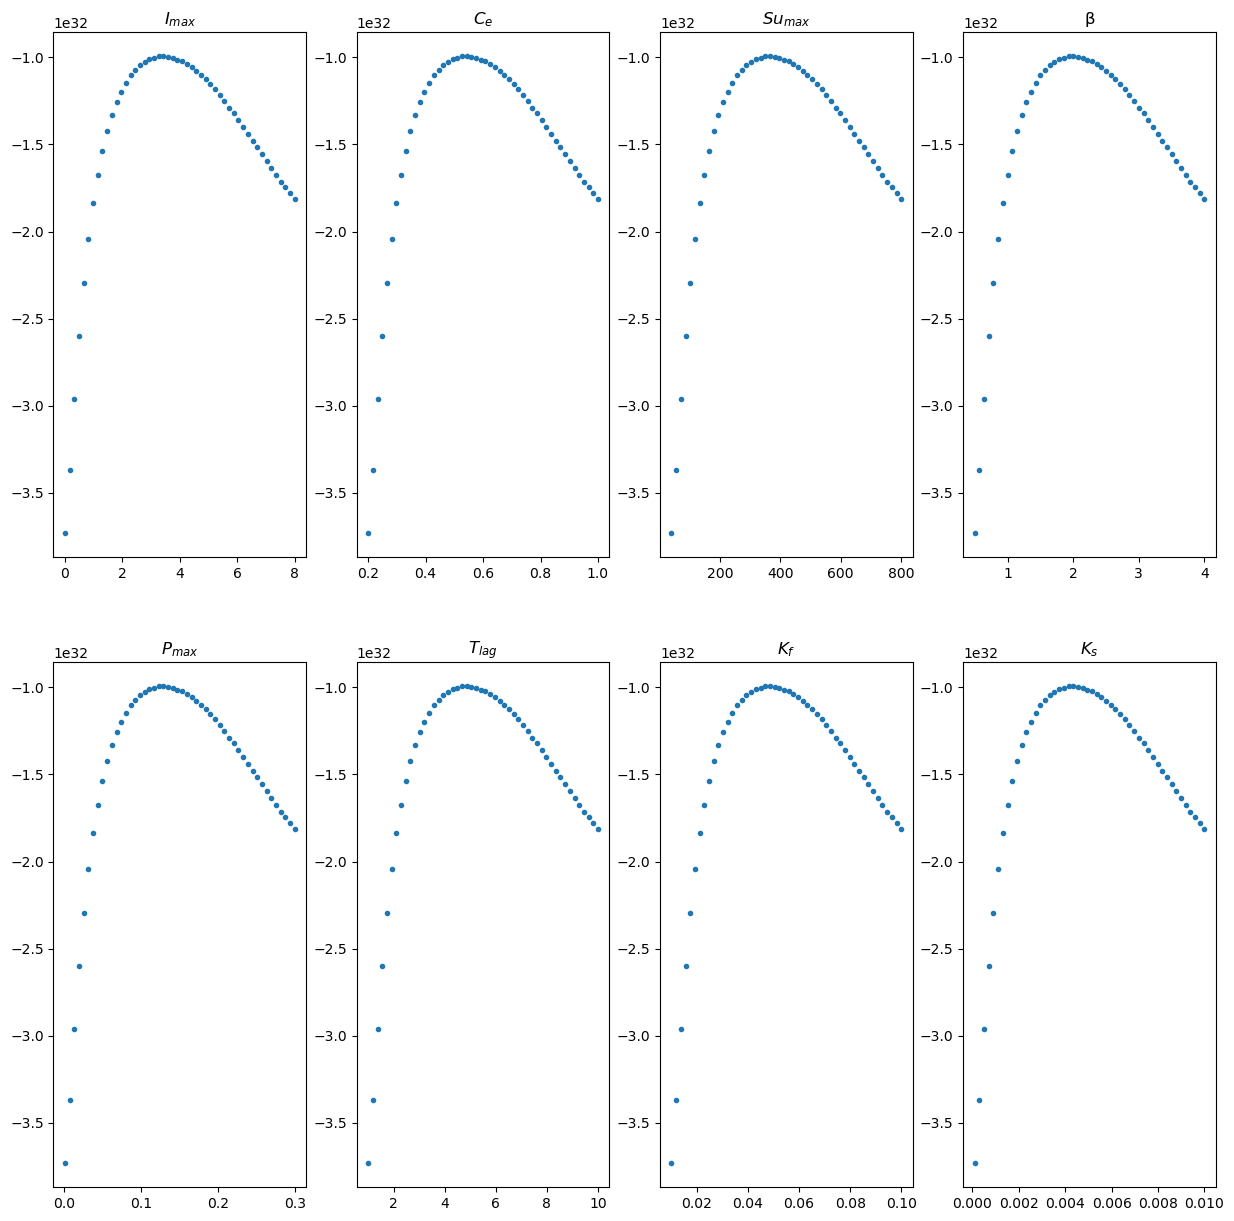

In [15]:
xFigNr = 2
yFigNr = 4

fig, axs = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

for xFig in range(xFigNr):
    for yFig in range(yFigNr):
        paramCounter = xFig*yFigNr + yFig
        axs[xFig,yFig].plot(parameters[paramCounter,:],objectives,'.')
        axs[xFig,yFig].set_title(p_names[paramCounter])


In [16]:
# Let's also show the minimal values:
parameters_minimum_index = np.argmin(np.array(objectives))

parameters_minimum = parameters[:,parameters_minimum_index]

print(parameters_minimum)

[0.e+00 2.e-01 4.e+01 5.e-01 1.e-03 1.e+00 1.e-02 1.e-04]

# Exercise: Create your own calibration method!

### Calibration 
As mentioned above: the method of choosing parameters is bad and the objective function is also far from optimal in this notebook. In this exercise, you will again an ensemble, but now you are asked to use another method to create the parameters and use Nash and Sutcliffe coefficient as the objective function. Calculate both the normal NSE and the log(NSE). Compare both and see (and understand) what the difference is between them?

The Nash and Sutcliffe coefficient is calculated using the formula:


\begin{equation}
    N = 1 - \frac{\sum_{i=1}^{n}(Q_{o,i} - Q_{m,i})^2}{\sum_{i=1}^{n}(O_{o,i} - \bar{O}_{o})^2}
\end{equation}

Where Q is discharge, the subscripts o and m stand for observed and modeled respectively, i is the time step, and the overbar indicates an average.



Use the code cells below to create the calibration method. Calculate the NSE value for 5000 ensemble members. Re-use the structure of the code above and edit it to create a randomly chosen parameter set and calculate the objectives NSE and Log(NSE). What is the optimal parameter set for your region?

In [17]:
#                   Imax Ce Sumax beta Pmax   Tlag   Kf  Ks
ParMinn = np.array([0,   0.2,  40,    .5,   .001,   0,     .01,  .0001])
ParMaxn = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
Sin = np.array([0,  100,  0,  5  ])

In [18]:
# Create a random parameter set based on the ParMinn and ParMaxn array. 
# Do not use np.linspace as above. 

import warnings
warnings.filterwarnings("ignore")

N = 5000

parameters = np.zeros([8, N])

for param in range(8):
    # parameters[param,:] = np.linspace(p_min_initial[param],p_max_initial[param],N)
    parameters[param,:] = np.random.uniform(ParMinn[param],ParMaxn[param],N)


# parameters = np.random.uniform(low = ParMinn, high = ParMaxn, size = [N,8])
# parameters = np.transpose(parameters)
print(parameters.shape)

(8, 5000)

In [19]:
# import warnings
# import io
# from IPython.core.display import display, HTML

# # Create a buffer to capture warning messages
# warning_buffer = io.StringIO()

# # Capture warnings
# with warnings.catch_warnings(record=True) as w:
#     warnings.simplefilter("always")  # Capture all warnings

#     # Run your code that generates warnings here
#     for counter in range(N): 
#         ensemble.append(HBV(forcing=ERA5_forcing))
#         config_file, _ = ensemble[counter].setup(
#             parameters=','.join([str(p) for p in parameters[:, counter]]),
#             initial_storage=','.join([str(s) for s in s_0]),
#             cfg_dir="configFiles/hbv_ensembleMember_" + str(counter),
#         )
#         ensemble[counter].initialize(config_file)

#     # Write all warnings to buffer
#     for warning in w:
#         warning_buffer.write(f"{warning.message}\n")

# # Display captured warnings in a scrollable output box
# display(HTML(f"""
# <div style="max-height: 300px; overflow-y: auto; border: 1px solid black; padding: 10px; background-color: #f8d7da; color: #721c24;">
# <pre>{warning_buffer.getvalue()}</pre>
# </div>
# """))

In [20]:
ensemble = []

for counter in range(N): 
    ensemble.append(HBV(forcing=ERA5_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = ','.join([str(p) for p in parameters[:,counter]]),
                            initial_storage=','.join([str(s) for s in s_0]),
                            cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
                               )
    ensemble[counter].initialize(config_file)

In [21]:
# ensemble = []

# for counter in range(N): 
#     ensemble.append(HBV(forcing=ERA5_forcing))
#     config_file, _ = ensemble[counter].setup(
#                             parameters = ','.join([str(p) for p in parameters[:, counter]]),
#                             initial_storage=','.join([str(s) for s in s_0]),
#                             cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
#                                )
#     ensemble[counter].initialize(config_file)

    

In [22]:
# # We use the same initial conditions for all models in the ensemble

# s_0 = np.array([0,  100,  0,  5])
# S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]

# # The names of the parameters are (luckily ;-) ) also constant for all models
# p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
# param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]

# # The number of ensemble members in our ensemble
# N = 50

# p_min_initial = np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
# p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])


# parameters = np.zeros([8, N])

# # Here I use np.linspace to make a linear interpolation between the minimum and maximum parameters. 
# # Realize that this means that the first model will get all low parameters and the last model will get all high parameters. 
# # This can be done much smarter.
# for param in range(8):
#     parameters[param,:] = np.linspace(p_min_initial[param],p_max_initial[param],N)

# np.shape(parameters)

# ensemble = []

# for counter in range(N): 
#     ensemble.append(HBV(forcing=ERA5_forcing))
#     config_file, _ = ensemble[counter].setup(
#                             parameters = ','.join([str(p) for p in parameters[:,counter]]),
#                             initial_storage=','.join([str(s) for s in s_0]),
#                             cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
#                                )
#     ensemble[counter].initialize(config_file)


In [23]:
# Create new objective function:

def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
    
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate difference
    diff = hydro_data['Observations from GRDC'] - hydro_data['model output']
    diff_mean = hydro_data['Observations from GRDC'] - np.nanmean(hydro_data['Observations from GRDC'])
    nse = 1 - (np.nansum(diff**2)/np.nansum(diff_mean**2))

    diff_log =  np.log10(hydro_data['Observations from GRDC']) - np.log10(hydro_data['model output'])
    diff_mean_log = np.log10(hydro_data['Observations from GRDC']) - np.log10(np.nanmean(hydro_data['Observations from GRDC']))
    log_nse = 1 - (np.nansum(diff_log**2)/np.nansum(diff_mean_log**2))

    return nse, log_nse

    
       

# def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
#     # A function that takes in two dataFrames, interpolates the model output to the
#     # observations and calculates the average absolute difference between the two.

#     #combine the two in one dataFrame
#     hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

#     #only select the calibration period
#     hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
#     hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

#     #calculate mean absolute difference

#     diff = hydro_data['Observations from GRDC'] - hydro_data['model output']
#     absDiff = np.abs(diff)
#     meanAbsDiff = np.mean(absDiff)

#     return meanAbsDiff

In [24]:
# An object to show a progress bar, since this can take a while:
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar

# An empty array to store the results in
objectives = []

# Loop over all ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q") * shape_area / (1000 * 86400) #"Q" refers to model output
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))
    
    # Calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective(discharge_dataframe,grdc_obs,calibration_start_time,calibration_end_time)
    objectives.append(objective_this_model)

    # It is good practice to remove any variable you don't need anymore to save memory.
    del Q_m, time, discharge_dataframe, objective_this_model

    #update progress bar
    f.value += 1

# Finaly, just like before, we remove the models themselves to save up space and memory.
for ensembleMember in ensemble:
    ensembleMember.finalize()

IntProgress(value=0, max=5000)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [25]:
# objectives

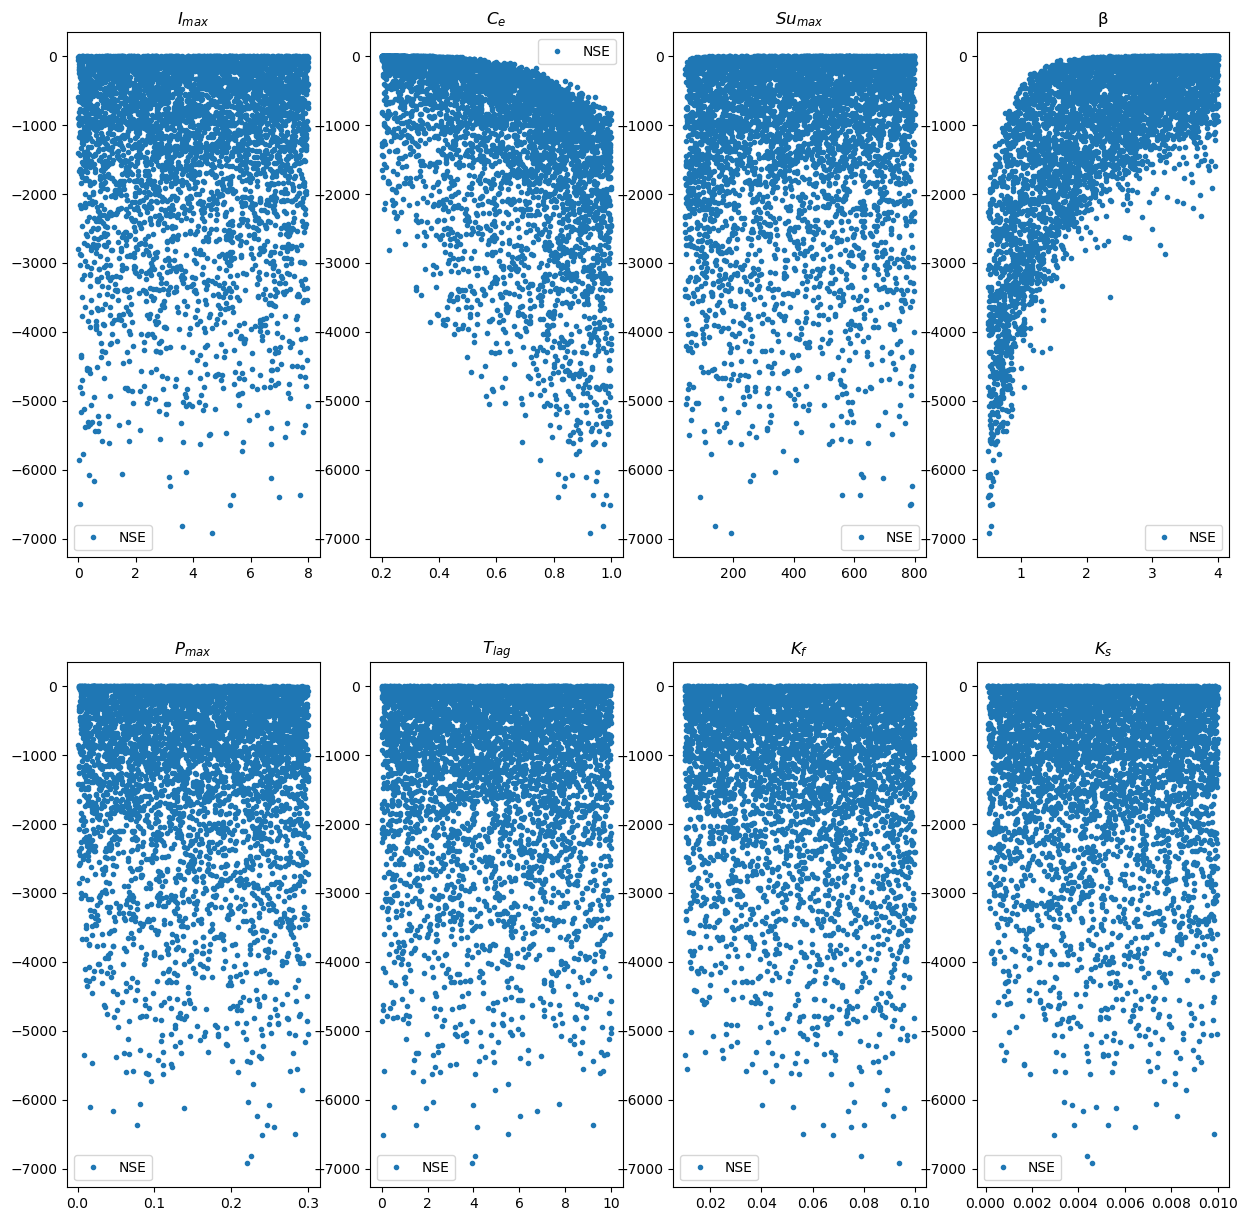

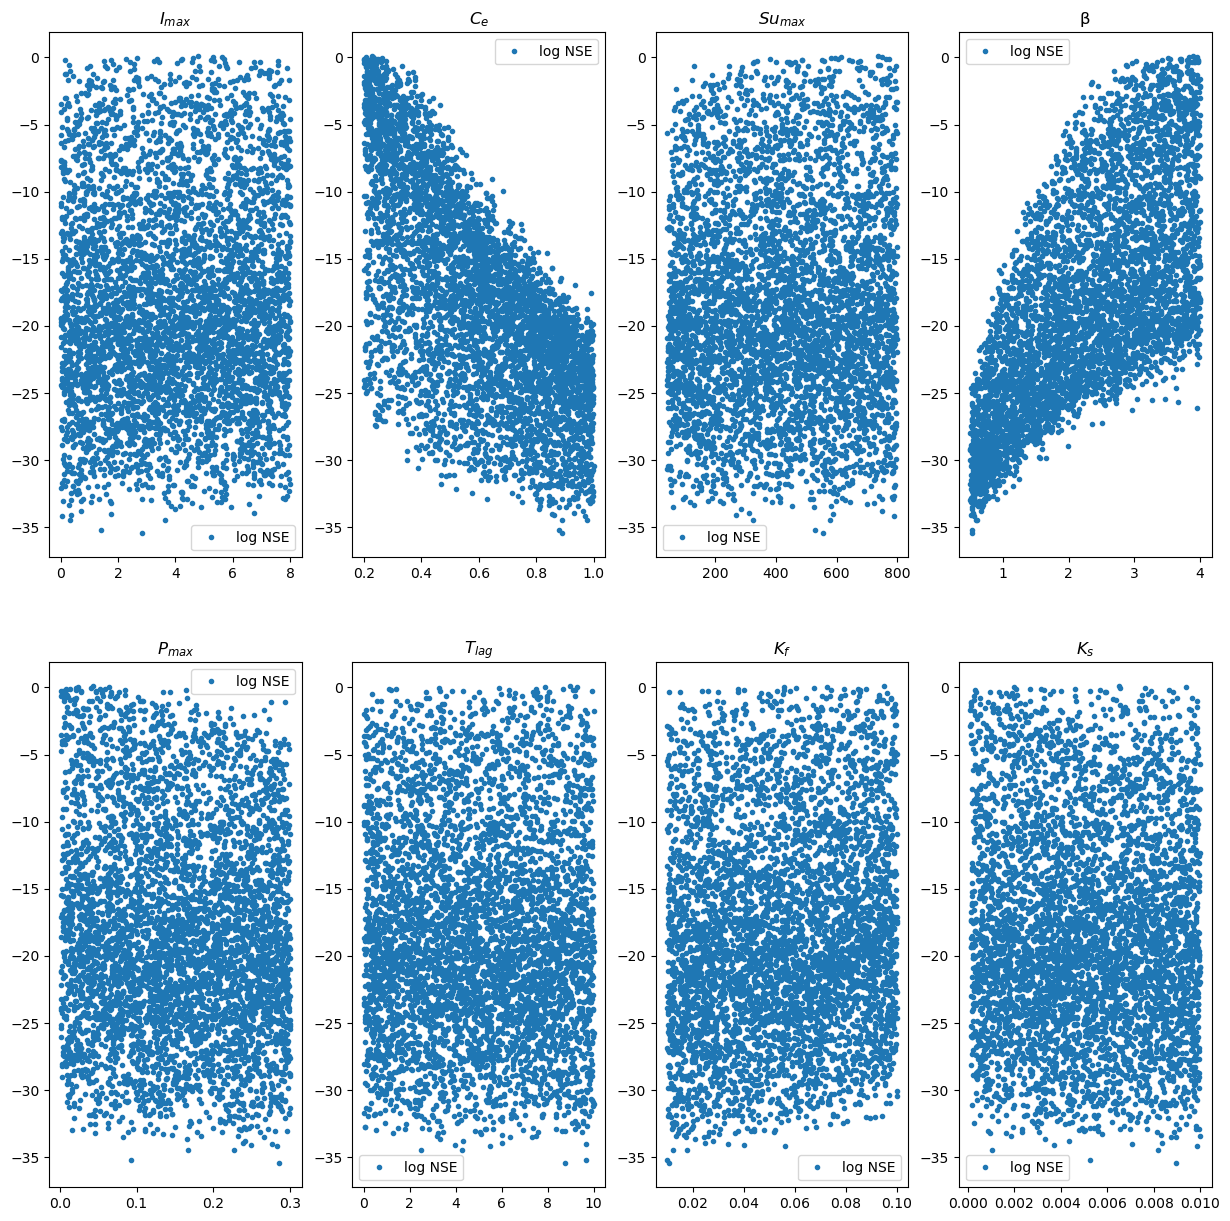

In [31]:
xFigNr = 2
yFigNr = 4

fig_nse, axs_nse = plt.subplots(xFigNr, yFigNr,figsize = (15,15))
fig_nselog, axs_nselog = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

for xFig in range(xFigNr):
    for yFig in range(yFigNr):
        paramCounter = xFig*yFigNr + yFig
        # Extract NSE and log NSE for all runs
        # nse_values = objectives[:, 0] #objectives is a list of tuples, so this goes wrong
        # log_nse_values = objectives[:, 1]
        nse_values = [i[0] for i in objectives]
        log_nse_values = [i[1] for i in objectives]
        
        axs_nse[xFig,yFig].plot(parameters[paramCounter,:],nse_values,'.', label='NSE')
        axs_nse[xFig,yFig].set_title(p_names[paramCounter])
        
        axs_nselog[xFig,yFig].plot(parameters[paramCounter,:],log_nse_values,'.', label='log NSE')
        axs_nselog[xFig,yFig].set_title(p_names[paramCounter])

        axs_nse[xFig,yFig].legend()
        axs_nselog[xFig,yFig].legend()


In [38]:
nse_values = [i[0] for i in objectives]
log_nse_values = [i[1] for i in objectives]

# Minimum values for nse:
parameters_maximum_index = np.argmax(np.array(nse_values))

parameters_maximum = parameters[:,parameters_maximum_index]

print(parameters_maximum, np.max(np.array(nse_values)))

# and for log nse:
log_parameters_maximum_index = np.argmax(np.array(log_nse_values))

log_parameters_maximum = parameters[:,log_parameters_maximum_index]

print(log_parameters_maximum, np.max(np.array(log_nse_values)))

[1.59443993e-01 2.00522982e-01 4.86777405e+02 3.79478589e+00
 8.51980948e-02 1.20419221e+00 8.55443218e-02 5.67879330e-03] -0.009979949701415913

[4.78194285e+00 2.27920726e-01 7.35686951e+02 3.89232692e+00
 4.34549098e-02 8.95329327e+00 9.48565150e-02 6.50368565e-03] 0.09852737524164423

### Validation
If you look carefully in the first few cells of this notebook, you can see that a different calibration and validation period is added. You can extend this notebook and calculate the values of the objective function for the validation period: how does the model perform for the periods where it was not calibrated for?

## Note on files

Each model now has its own directory in the configFiles directory. If everything goes well, these are deleted with the ```finalize()``` command above. If however due to an error, they persist, you may not be able to create a new ensemble. In that case, uncomment the line in the cell below and run that. But be careful! this will remove all the files in the configFiles directory.

In [28]:
#!rm -r configFiles/*